# Ciência de Dados aplicada à otimização do planejamento de manutenção

### Bibliotecas

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/datasetbix'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from ydata_profiling import ProfileReport
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## modelo
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter

# check xgboost version
from xgboost import XGBClassifier

import timeit
import warnings
warnings.filterwarnings("ignore")

### Layout

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### Configurações

In [ ]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

# Define um valor maior para a largura máxima das colunas
pd.options.display.max_colwidth = 1000

seed = 42
np.random.seed(seed)

### Funções

In [ ]:
def check_time(start, end):
    seg = end - start
    dias = seg // 86400
    Seg_Restantes_Após_Dias = seg % 86400
    horas = Seg_Restantes_Após_Dias // 3600         # Divisão inteira
    Seg_Restantes_Apos_Hora = seg % 3600            # Resto da divisão por 3600
    minutos = Seg_Restantes_Apos_Hora // 60         # Divisão inteira dos segundos restantes
    Seg_Restantes_Apos_Minutos = seg % 60
    #print(minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')
    print(dias,'dias', horas,'horas', minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')

start=timeit.default_timer()

In [ ]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [ ]:
def plot_feature_freq(df, feature, top_n=10):
    value_counts = df[feature].value_counts(dropna=True)
    top_values = value_counts.head(top_n)
    other_values_count = value_counts.iloc[top_n:].sum()

    if other_values_count > 0:
        top_values['Outros'] = other_values_count

    total = top_values.sum()

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')

    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        percentage = p.get_height() / total * 100
        ax.annotate('{:.1f}%'.format(percentage), (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', xytext=(0, -40), textcoords='offset points')

    ax.set(xlabel='isFraud', ylabel='Quantidade')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def convert_to_int(df):
    # Substituir 'na' por NaN
    df.replace('na', np.nan, inplace=True)

    # Identificar colunas numéricas e converter para inteiro
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass  # Ignorar colunas que não podem ser convertidas para numérico

    # Converter colunas numéricas para inteiros, ignorando NaNs
    df = df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
    
    # Garantir que todas as colunas numéricas sejam do tipo int64
    for col in df.select_dtypes(include=['Int64', 'float', 'Int32']).columns:
        df[col] = df[col].astype('Int64')
    
    return df

***
# 1) Definição do problema e objetivo do projeto

## 1.1) Contexto

Uma nova empresa de consultoria em ciência de dados foi contratada para solucionar e aprimorar o planejamento de manutenção de uma empresa terceirizada de transporte. A empresa mantém um número médio de caminhões em sua frota para fazer entregas em todo o país, mas nos últimos 3 anos vem percebendo um grande aumento nos gastos relacionados à manutenção do sistema de ar de seus veículos, mesmo tendo sido mantido o tamanho da sua frota relativamente constante. O custo de manutenção deste sistema específico é mostrado abaixo em dólares:

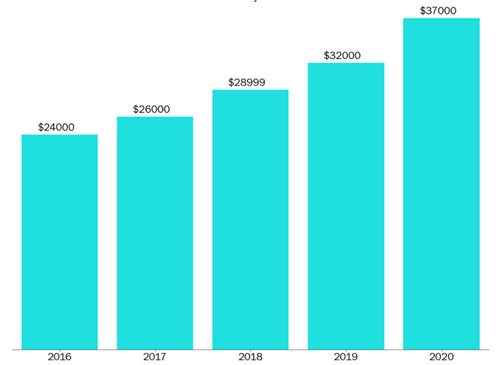
 
Seu objetivo como consultor é diminuir os custos de manutenção deste sistema específico. Os custos de manutenção do sistema de ar podem variar dependendo das condições reais do caminhão.

-	Caso um caminhão seja enviado para manutenção, mas não apresente nenhum defeito nesse sistema, serão cobrados cerca de R$10 pelo tempo gasto na inspeção pela equipe especializada.
-	Caso um caminhão seja enviado para manutenção e apresente defeito neste sistema, serão cobrados R$25 para realizar o serviço de reparo preventivo.
-	Caso um caminhão com defeito no sistema de ar não seja enviado diretamente para manutenção, a empresa paga R$500 para realizar a manutenção corretiva do mesmo, considerando mão de obra, reposição de peças e outros possíveis inconvenientes (caminhão quebrou no meio da pista por exemplo).

Durante a reunião de alinhamento com os responsáveis pelo projeto e a equipe de TI da empresa, algumas informações foram passadas para você:

-	A equipe técnica informou que todas as informações referentes ao sistema aéreo dos caminhos serão disponibilizadas para você, mas por questões burocráticas em relação aos contratos da empresa, todas as colunas tiveram que ser codificadas.
-	A equipa técnica informou ainda que dada a recente digitalização da empresa, poderão faltar algumas informações na base de dados que lhe foi enviada.

Por fim, a equipe técnica informou que a fonte da informação vem do setor de manutenção da empresa, onde criaram uma coluna no banco de dados chamada classe : “pos” seriam aqueles caminhões que apresentavam defeitos no sistema de ar e “neg” seria aqueles caminhões que apresentavam defeito em qualquer sistema que não fosse o de ar.

Os responsáveis pelo projeto estão muito entusiasmados com a iniciativa e, ao solicitarem uma prova técnica de conceito, colocaram como principais requisitos:
-	Podemos reduzir nossos gastos com esse tipo de manutenção utilizando técnicas de IA?
-	Você pode me apresentar os principais fatores que apontam para uma possível falha neste sistema?
Esses pontos, segundo eles, são importantes para convencer a diretoria executiva a abraçar a causa e aplicá-la em outros sistemas de manutenção durante o ano de 2022.


## 1.1) Dicionario de dados

- “pos” seriam aqueles caminhões que apresentavam defeitos no sistema de ar

- “neg” seria aqueles caminhões que apresentavam defeito em qualquer sistema que não fosse o de ar.

***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - Modelagem

In [ ]:
client_chunks = []
previous_years_data_amostra = pd.read_csv('/kaggle/input/datasetbix/air_system_previous_years.csv', 
                                          header = 0, 
                                          index_col = False, 
                                          names = None, 
                                          low_memory = False, 
                                          chunksize = 10**5) 

In [ ]:
for chunk in previous_years_data_amostra:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
    new_clients = new_clients.sample(frac = 0.1)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

previous_years_data = pd.concat(client_chunks).reset_index(drop = True)

In [ ]:
previous_years_data.shape

## 2.2) Converte os valores para INT e substitui NA por NaN (not a number)

In [ ]:
previous_years_data = convert_to_int(previous_years_data)

In [ ]:
previous_years_data.head()

In [ ]:
previous_years_data.dtypes.value_counts()

## 2.3) Verificar valores ausentes

In [ ]:
just_check_nan(previous_years_data)

***
# 3) Preparação dos dados

## 3.1) Features

In [ ]:
X = previous_years_data.drop(['class'], axis=1)

## 3.1) Imputando dados ausentes com KNNImputer

In [ ]:
# Inicialize o KNN Imputer com o número de vizinhos desejado
imputer = KNNImputer()

# Impute os valores faltantes
X_imputed = imputer.fit_transform(X)

### 3,2) Seleção do Target

### 3.2.1) One Hot encoding no Target

In [ ]:
previous_years_data['class'] = previous_years_data['class'].map({'pos': 1, 'neg': 0})

In [ ]:
# define target
y = previous_years_data['class']
y

## - Dados 'neg' são representados por 0

## - Dados 'pos' são representados por 1

### 2.2.2) Variaveis Categoricas

In [ ]:
# Criando uma lista de variaveis categoricas
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

### 2.2.3) Variaveis Numéricas

In [ ]:
# Criando uma lista de variáveis numéricas
numerical_cols = [cname for cname in X.columns if pd.api.types.is_numeric_dtype(X[cname])]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

***
# 3) Modelagem

In [ ]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.7, 
                                                  random_state = 2048)

In [ ]:
model = XGBClassifier(random_state=2048)
model.fit(X_train, y_train)
preds = model.predict(X_val)

***
# 4) Analise de features para o modelo

## 4.1) Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=1000).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

## 4.2) SHAP Values

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_valid)

## 4.3) Summary Plot

In [ ]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = X_train.sample(n=min(10, len(X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = X_val.sample(n=int((X_val.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)